# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Msc. BDS - M7 Second Semester Project** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:

1. Load new batch data.
2. Predict using model from Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages

We start by accessing the folder we have created that holds the functions (incl. live API calls and data preprocessing) we need for electricity prices, weather measures, and calendar. Then, we proceed to import some of the necessary libraries needed for this notebook and warnings to avoid unnecessary distractions and keep output clean.

In [1]:
# First we go one back in our directory to access the folder with our functions
%cd ..

# Now we import the functions from the features folder
# This is the functions we have created to generate features for weather measures and calandar
from features import weather_measures, calendar, electricity_prices  

# We go back into the notebooks folder
%cd pipeline

/Users/tobiasmjensen/Documents/aau_bds/m7_second-semester-project/bds_m7_second-semester-project
/Users/tobiasmjensen/Documents/aau_bds/m7_second-semester-project/bds_m7_second-semester-project/pipeline


In [2]:
# Importing pandas for data handling
import pandas as pd
import numpy as np
import tensorflow as tf

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store
We connect to the Hopsworks Feature Store so we can retrieve the Feature View, access the Model Registry, and retrieve the saved model from training.

In [3]:
# Importing the hopsworks module
import hopsworks

# Logging into the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/554133
Connected. Call `.close()` to terminate connection gracefully.


### <span style='color:#2656a3'> ⚙️ Feature View Retrieval

In [4]:
# Retrieve the 'dk1_electricity_training_feature_view' feature view
feature_view_training = fs.get_feature_view(
    name='lstm_electricity_price_feature_view',
    version=1,
)

In [5]:
# Retrieve training data from the feature view 'feature_view_training', assigning the features to 'X'.
df, _ = feature_view_training.training_data(
    description = 'LSTM Electricity Prices Training Dataset',
)

Finished: Reading data from Hopsworks, using ArrowFlight (4.99s) 


### <span style='color:#2656a3'> 📮 Retrieving model from Model Registry

In [6]:
# Retrieve the model registry
mr = project.get_model_registry()

# Retrieving the TensorFlow model from the Model Registry
model = mr.get_model(
    name="lstm_electricity_price_model", 
    version=1,
)

Connected. Call `.close()` to terminate connection gracefully.


In [7]:
# Downloading the model to a local directory
model_dir = model.download()

# Loading the saved TensorFlow model
loaded_model = tf.saved_model.load(model_dir)

# Accessing the serving function of the loaded model
serving_function = loaded_model.signatures["serving_default"]

 The `"serving_default"` function from the loaded model's signatures. This serving function is designed for inference and is the entry point for making predictions with the model

### <span style='color:#2656a3'> 📮 Retrieving model from Directory (if HopsWorks doesn't work)

In [8]:
import os

# Define the directory where the model is stored
model_dir = "../pipeline/lstm_electricity_price_model"

# List the contents of the model directory
print(os.listdir(model_dir))

['fingerprint.pb', 'variables', 'saved_model.pb', 'assets']


In [9]:
# Load the model
loaded_model = tf.saved_model.load(model_dir)

# Print the loaded model to verify
print(loaded_model)

# Accessing the serving function of the loaded model
serving_function = loaded_model.signatures["serving_default"] # Load the serving function of the model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x34598f110>


## <span style='color:#2656a3'> ✨ Load New Data
Our objective is to predict the electricity prices for the upcoming days, therefore we load a weather forecast as batch data to make predictions.

In [10]:
# Fetching weather forecast measures for the next 5 days
weather_forecast_df = weather_measures.forecast_weather_measures(
    forecast_length=5
)

# Fetching danish calendar
calendar_df = calendar.calendar_denmark(
    freq='H',
)

# Fetching the electricity prices
electricity_price_df = electricity_prices.electricity_prices(
    historical=True,
    area=["DK1"],
    start='2020-01-01'
)

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In [11]:
# Merging the weather forecast and calendar dataframes
new_data = pd.merge(weather_forecast_df, calendar_df, how='inner', left_on='timestamp', right_on='timestamp')

# Displaying the new data
new_data.tail()

,timestamp,datetime_x,date_x,hour_x,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,...,wind_speed_10m,wind_gusts_10m,datetime_y,date_y,hour_y,dayofweek,day,month,year,workday
115,1717009200000,2024-05-29 19:00:00,2024-05-29,19,15.4,74.0,0.0,0.0,0.0,61.0,...,16.5,33.1,2024-05-29 19:00:00,2024-05-29,19,2,29,5,2024,1
116,1717012800000,2024-05-29 20:00:00,2024-05-29,20,15.3,75.0,0.0,0.0,0.0,61.0,...,16.5,33.8,2024-05-29 20:00:00,2024-05-29,20,2,29,5,2024,1
117,1717016400000,2024-05-29 21:00:00,2024-05-29,21,15.1,76.0,0.0,0.0,0.0,61.0,...,16.9,34.2,2024-05-29 21:00:00,2024-05-29,21,2,29,5,2024,1
118,1717020000000,2024-05-29 22:00:00,2024-05-29,22,14.6,80.0,1.0,1.0,0.0,61.0,...,17.4,36.0,2024-05-29 22:00:00,2024-05-29,22,2,29,5,2024,1
119,1717023600000,2024-05-29 23:00:00,2024-05-29,23,14.0,85.0,1.0,1.0,0.0,61.0,...,18.2,38.2,2024-05-29 23:00:00,2024-05-29,23,2,29,5,2024,1


In [12]:
# Dropping and renaming columns
new_data.drop(columns=['datetime_y', 'hour_y', 'date_y'], inplace=True)
new_data.rename(columns={
    'date_x': 'date', 
    'datetime_x': 'datetime', 
    'hour_x': 'hour'}, inplace=True)

# Displaying the new data
new_data.tail()

,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
115,1717009200000,2024-05-29 19:00:00,2024-05-29,19,15.4,74.0,0.0,0.0,0.0,61.0,97.0,16.5,33.1,2,29,5,2024,1
116,1717012800000,2024-05-29 20:00:00,2024-05-29,20,15.3,75.0,0.0,0.0,0.0,61.0,98.0,16.5,33.8,2,29,5,2024,1
117,1717016400000,2024-05-29 21:00:00,2024-05-29,21,15.1,76.0,0.0,0.0,0.0,61.0,100.0,16.9,34.2,2,29,5,2024,1
118,1717020000000,2024-05-29 22:00:00,2024-05-29,22,14.6,80.0,1.0,1.0,0.0,61.0,100.0,17.4,36.0,2,29,5,2024,1
119,1717023600000,2024-05-29 23:00:00,2024-05-29,23,14.0,85.0,1.0,1.0,0.0,61.0,100.0,18.2,38.2,2,29,5,2024,1


In [13]:
# Sort the retrived training data from the feature view based on the values in the 'timestamp' column in ascending order
df.sort_values(by='timestamp', ascending=True, inplace=True)

# Reset the index of the DataFrame 'df'
df = df.reset_index(drop=True)

# Display the last few rows of the DataFrame 'df' after sorting and resetting the index
df.tail()

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
38522,1716620400000,2024-05-25 07:00:00+00:00,2024-05-25 00:00:00+00:00,7,0.64335,15.8,66.0,0.0,0.0,0.0,2.0,77.0,3.2,11.2,5,25,5,2024,0
38523,1716624000000,2024-05-25 08:00:00+00:00,2024-05-25 00:00:00+00:00,8,0.58628,17.1,65.0,0.0,0.0,0.0,2.0,56.0,6.1,13.7,5,25,5,2024,0
38524,1716627600000,2024-05-25 09:00:00+00:00,2024-05-25 00:00:00+00:00,9,0.55770,18.1,67.0,0.0,0.0,0.0,3.0,96.0,7.6,15.8,5,25,5,2024,0
38525,1716631200000,2024-05-25 10:00:00+00:00,2024-05-25 00:00:00+00:00,10,0.40460,19.9,63.0,0.0,0.0,0.0,3.0,90.0,9.0,21.2,5,25,5,2024,0
38526,1716634800000,2024-05-25 11:00:00+00:00,2024-05-25 00:00:00+00:00,11,0.06968,21.1,62.0,0.0,0.0,0.0,3.0,97.0,9.4,22.3,5,25,5,2024,0


In [14]:
electricity_price_df

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh
0,1577836800000,2020-01-01 00:00:00,2020-01-01,0,0.24965
1,1577840400000,2020-01-01 01:00:00,2020-01-01,1,0.23733
2,1577844000000,2020-01-01 02:00:00,2020-01-01,2,0.23583
3,1577847600000,2020-01-01 03:00:00,2020-01-01,3,0.23366
4,1577851200000,2020-01-01 04:00:00,2020-01-01,4,0.23045
...,...,...,...,...,...
38534,1716577200000,2024-05-24 19:00:00,2024-05-24,19,0.97001
38535,1716580800000,2024-05-24 20:00:00,2024-05-24,20,0.93277
38536,1716584400000,2024-05-24 21:00:00,2024-05-24,21,0.86442
38537,1716588000000,2024-05-24 22:00:00,2024-05-24,22,0.81838


In [15]:
# Append new data to the historical data stored in the DataFrame 'df'
combined_data = pd.concat([electricity_price_df, new_data], ignore_index=True)

In [16]:
# Only keep the last 120 hours of data for the forecast
# The past 24 hours from historical data for the 24 hour sequence
forecast_data = combined_data.tail(120+24)

In [17]:
# Drop columns 'dk1_spotpricedkk_kwh', 'timestamp', 'datetime', and 'date' from the DataFrame 'forecast_data'
forecast_data.drop(columns=['dk1_spotpricedkk_kwh','timestamp', 'datetime', 'date'], inplace=True)

#### <span style="color:#2656a3;">👆 Feature Selection and Preprocessing</span>

In [18]:
from sklearn.preprocessing import MinMaxScaler
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit_transform(df[['dk1_spotpricedkk_kwh']])

array([[0.36153891],
       [0.36027605],
       [0.36012229],
       ...,
       [0.39311555],
       [0.37742205],
       [0.3430911 ]])

In [19]:
# Selecting the relevant features and target
features = new_data.drop(columns=['datetime','date','timestamp'])

# Scaling the features and target
scaler_features = MinMaxScaler()

features_scaled = scaler_features.fit_transform(features)

data = np.array(features_scaled)

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In [20]:
# Prepare the data for LSTM model for the X_new_data
time_steps = 25 # 25 hours to get 00:00 hour in the sequence

# Create a list to store the sequences
X_new_data = []
for i in range(len(data) - time_steps + 1):
    X_new_data.append(data[i:(i + time_steps), :])
X_new_data = np.array(X_new_data)

## <span style="color:#2656a3;">🤖 Making the predictions</span>

We now want to make predictions based on our trained model from Hopsworks and the forecasted weather measures.

In [21]:
# Using the serving function to make predictions
x = serving_function(tf.constant(X_new_data, dtype=tf.float32))

# Extracting and converting the predictions to a NumPy array
predictions = x[list(x.keys())[0]].numpy()

# Inverse transform the predictions to get the original scale
predictions = target_scaler.inverse_transform(predictions)

print(predictions)

[[ 0.14454302]
 [ 0.15722658]
 [ 0.15207553]
 [ 0.15182056]
 [ 0.1540328 ]
 [ 0.1489114 ]
 [ 0.1415045 ]
 [ 0.12263689]
 [ 0.08789778]
 [ 0.04718133]
 [ 0.00484487]
 [-0.02527148]
 [-0.04370442]
 [-0.01987359]
 [ 0.02745837]
 [ 0.04649053]
 [ 0.06529126]
 [ 0.09423126]
 [ 0.10909246]
 [ 0.08844844]
 [ 0.12010804]
 [ 0.08581055]
 [ 0.06061993]
 [ 0.07072984]
 [ 0.02373951]
 [ 0.00229624]
 [-0.0408386 ]
 [-0.00470625]
 [ 0.05443937]
 [ 0.09154366]
 [ 0.11637463]
 [ 0.11630835]
 [ 0.09700754]
 [ 0.08230044]
 [ 0.05099322]
 [ 0.00203224]
 [ 0.06623761]
 [-0.02599571]
 [ 0.03931651]
 [ 0.09762362]
 [ 0.21299234]
 [ 0.30868316]
 [ 0.32634562]
 [ 0.30445492]
 [ 0.32846802]
 [ 0.29335037]
 [ 0.24470077]
 [ 0.2086164 ]
 [ 0.20836811]
 [ 0.20120601]
 [ 0.18256025]
 [ 0.16808107]
 [ 0.16404589]
 [ 0.17070793]
 [ 0.17035206]
 [ 0.14734837]
 [ 0.10342244]
 [ 0.05903249]
 [ 0.01742578]
 [-0.01313249]
 [-0.02227511]
 [-0.01954331]
 [-0.01431202]
 [ 0.04058035]
 [ 0.04545113]
 [ 0.07255599]
 [ 0.09950

In [22]:
# Combine predictions with datetime index from new_data (adjust index as needed)
predictions_data = {
    'prediction': predictions.flatten(),  # Ensure predictions is 1D
    'time': new_data['datetime'][24:]  # Adjust index for look_back
}

# Create a DataFrame from the predictions data
predictions_df = pd.DataFrame(predictions_data)

# Display the new electricity price predictions
predictions_df

,prediction,time
24,0.144543,2024-05-26 00:00:00
25,0.157227,2024-05-26 01:00:00
26,0.152076,2024-05-26 02:00:00
27,0.151821,2024-05-26 03:00:00
28,0.154033,2024-05-26 04:00:00
...,...,...
115,0.035442,2024-05-29 19:00:00
116,0.026006,2024-05-29 20:00:00
117,0.018318,2024-05-29 21:00:00
118,-0.017095,2024-05-29 22:00:00


### <span style="color:#2656a3;">📊 Plot the predictions</span>

Now we plot the predictions as a linechart for the comming five days.
We are plotting the linechart with both matplotlib and Altair for interactive visualization.

2024-05-24 22:37:22,865 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



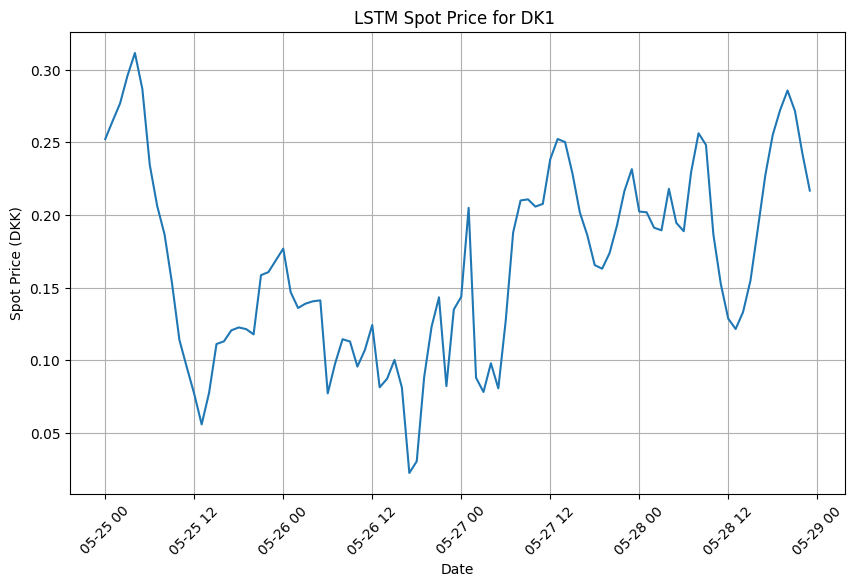

In [36]:
# Importing matplotlib for plotting
import matplotlib.pyplot as plt

# Group the data by date and calculate the average temperature for each day
daily_data = predictions_df.groupby('time')['prediction'].mean()
 
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index, daily_data.values)
plt.xlabel('Date')
plt.ylabel('Spot Price (DKK)')
plt.title('LSTM Spot Price for DK1 ')
plt.xticks(rotation=45)
plt.grid(True)
 
# Show the plot
plt.show()

In [37]:
# Importing Altair for interactive visualization
import altair as alt

# Create Altair chart with line and dots
chart = alt.Chart(predictions_df).mark_line(point=True).encode(
    x='time:T', 
    y='prediction:Q', 
    # Adding tooltips for interactive information display
    tooltip=[alt.Tooltip('time:T', title='Date', format='%Y-%m-%d'), 
             alt.Tooltip('time:T', title='Time', format='%H:%M'), 
             alt.Tooltip('prediction:Q', title='Spot Price (DKK)', format='.2f')
            ]
)
 
# Display the chart
chart.interactive()

2024-05-24 22:37:25,185 WARNING: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization. A future release will remove RefResolver. Please file a feature request (on referencing) if you are missing an API for the kind of customization you need.

2024-05-24 22:37:25,192 WARNING: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization. A future release will remove RefResolver. Please file a feature request (on referencing) if you are missing an API for the kind of customization you need.

2024-05-24 22:37:25,209 WARNING: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in favor of the https://g

alt.Chart(...)

---
## <span style="color:#2656a3;">⏭️ **Next:** Creating our Python files for a Streamlit application ([link to Github repository](https://github.com/tobiasmj97/bds_m7_second-semester-project_streamlit)) </span>
